In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
data = pd.read_csv('GazeData/gaze_data_all_trials.csv', sep=',')

# Define screen resolution (you can adjust this based on Unity's settings)
screen_width = 2560
screen_height = 1440

x and y plots

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_velocity_and_accuracy(df, screen_width, screen_height):
    # Compute Time Difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero

    # Compute Position Difference for Velocity
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second

    # Compute Accuracy Relative to Ball Position
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column, handling negative values
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    # Filter out rows where BallX or BallY is negative
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]

    # Calculate Accuracy in X and Y object_directions
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])

    return df

# Data structure to organize pair conditions
pair_conditions = {
    "diagonal_with": {
        "left_to_right": ["diagonal_left_up", "diagonal_left_down"],
        "right_to_left": ["diagonal_right_up", "diagonal_right_down"]
    },
    "diagonal_against": {
        "left_to_right": ["diagonal_right_up", "diagonal_right_down"],
        "right_to_left": ["diagonal_left_up", "diagonal_left_down"]
    },
    "vertical": {
        "left_to_right": ["vertical_up", "vertical_down"],
        "right_to_left": ["vertical_up", "vertical_down"]
    },
    "horizontal_with": {
        "left_to_right": ["horizontal_left"],
        "right_to_left": ["horizontal_right"]
    },
    "horizontal_against": {
        "left_to_right": ["horizontal_right"],
        "right_to_left": ["horizontal_left"]
    },
    "zero": {
        "left_to_right": ["zero"],
        "right_to_left": ["zero"]
    }
}

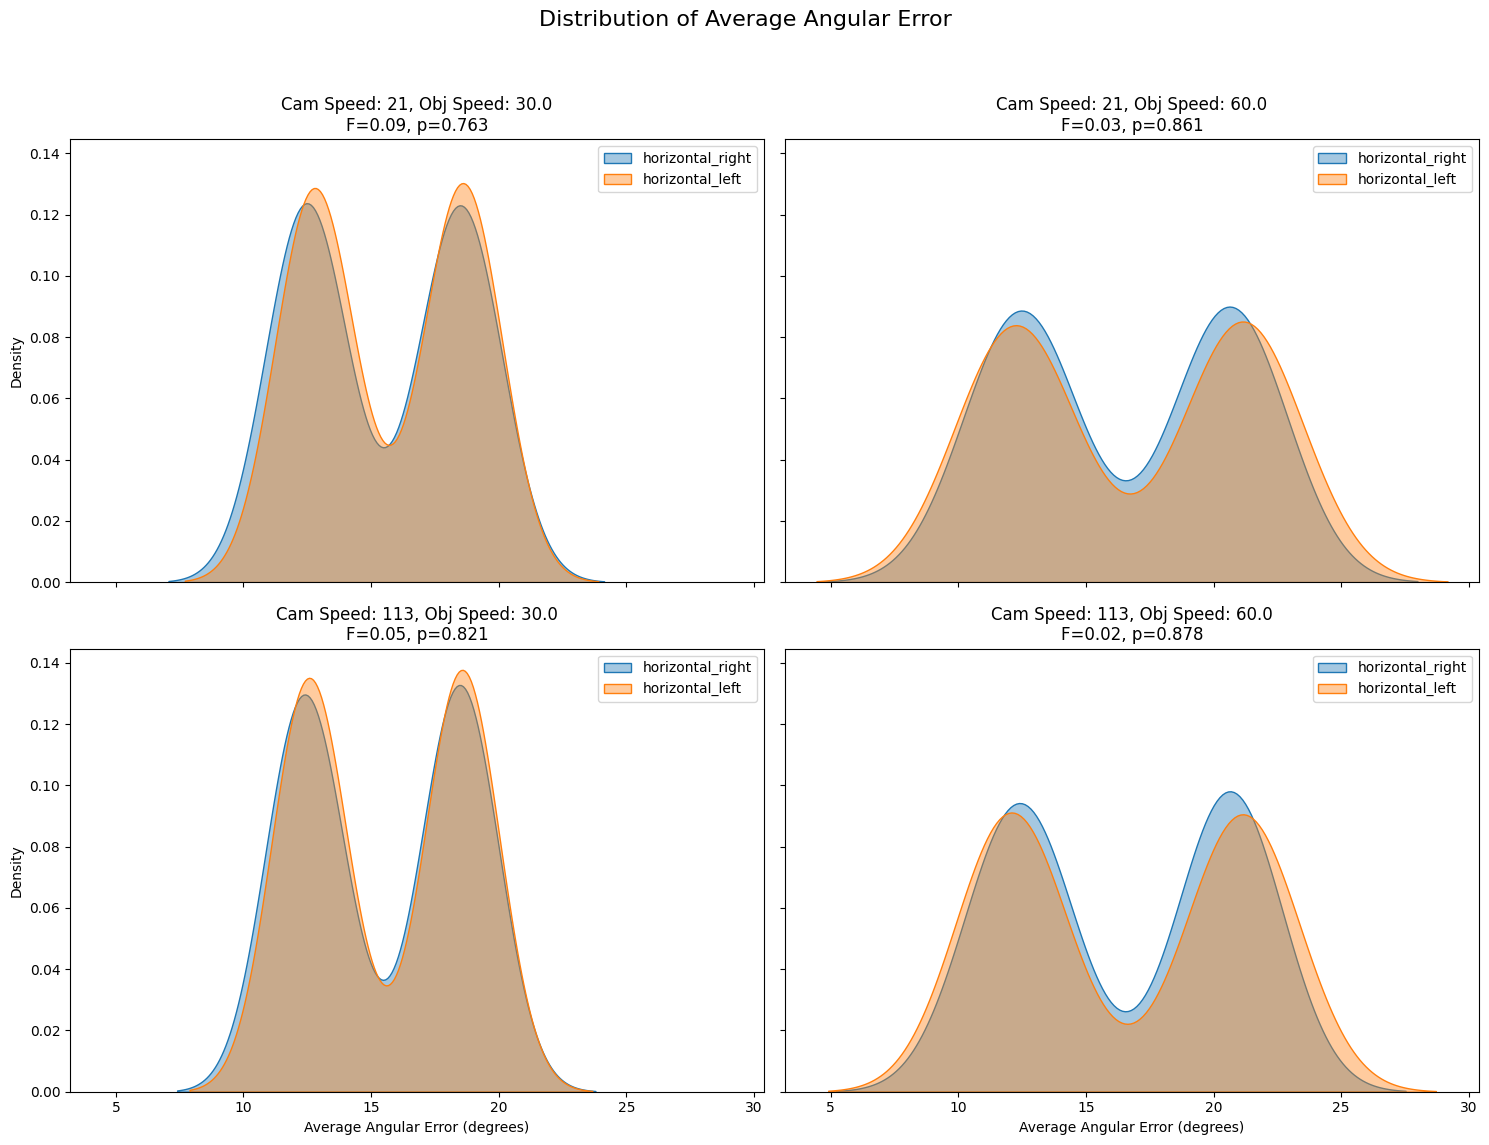

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns  # For smooth density plots

# Load the trial details CSV to map TrialID to camera motion type, object speed, and camera speed
trial_details_df = pd.read_csv("generated_trial_ids/generated_trials_ids.csv")
data = pd.read_csv('GazeData/gaze_data_all_trials.csv', sep=',')

# Map TrialID to camera motion type and object speed based on an external mapping file
def map_camera_motion_type_and_object_speed(data_df, trial_details_df):
    data_df = data_df.merge(trial_details_df[['trial_id', 'camera_motion_type', 'object_speed', 'camera_speed']],
                            left_on='TrialID', right_on='trial_id', how='left')
    return data_df

# Compute position-dependent angular error
def compute_position_dependent_angular_error(df, screen_width, screen_height, screen_diagonal_size, distance_to_screen):
    # Convert screen diagonal size to pixels
    diagonal_resolution = np.sqrt(screen_width**2 + screen_height**2)
    pixel_size = screen_diagonal_size / diagonal_resolution  # Inches per pixel
    distance_to_screen_pixels = distance_to_screen * (1 / pixel_size) * 39.37  # Convert meters to inches

    # Compute screen center
    screen_center_x = screen_width / 2
    screen_center_y = screen_height / 2

    # Compute distances
    df['PixelDistance'] = np.sqrt((df['MappedPogX'] - df['BallX'])**2 + (df['MappedPogY'] - df['BallY'])**2)
    df['TargetToCenterDistance'] = np.sqrt((df['BallX'] - screen_center_x)**2 + (df['BallY'] - screen_center_y)**2)

    # Adjust distance to screen based on target's position on screen
    df['DistanceToScreenAdjusted'] = np.sqrt(distance_to_screen_pixels**2 + df['TargetToCenterDistance']**2)

    # Compute angular error
    df['AngularError'] = np.degrees(np.arctan(df['PixelDistance'] / df['DistanceToScreenAdjusted']))
    
    return df

# Calculate average angular error per individual trial run across a given time frame for each condition
def calculate_average_angular_error_per_individual_trial(df, time_start=0, time_end=None, object_speed=None, camera_speed=None):
    filtered_df = df[(df['RelativeTime'] >= time_start) & (df['RelativeTime'] <= (time_end if time_end is not None else df['RelativeTime'].max()))]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]

    if object_speed is not None:
        filtered_df = filtered_df[filtered_df['object_speed'] == object_speed]
    if camera_speed is not None:
        filtered_df = filtered_df[np.isclose(filtered_df['camera_speed'], camera_speed, rtol=1)]

    # Calculate the average angular error per individual trial run within each TrialID
    avg_error_per_individual_trial = filtered_df.groupby(['camera_motion_type', 'TrialID', 'TrialNumber'])['AngularError'].mean().reset_index()
    return avg_error_per_individual_trial

# Perform ANOVA on the average angular error per individual trial run across specified camera motion types
def perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=None):
    if camera_motion_types is not None:
        avg_error_per_individual_trial = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'].isin(camera_motion_types)]
    
    # Organize the data by camera motion type for ANOVA
    error_data = [avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'] == motion_type]['AngularError'] 
                  for motion_type in avg_error_per_individual_trial['camera_motion_type'].unique()]

    if len(error_data) > 1:
        f_stat, p_value = f_oneway(*error_data)
        return {'F-statistic': f_stat, 'p-value': p_value}
    else:
        return {'F-statistic': None, 'p-value': None}  # Skip ANOVA if only one group

# Analyze combinations for angular error
def analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds):
    num_combinations = len(camera_speeds) * len(object_speeds)
    fig, axes = plt.subplots(len(camera_speeds), len(object_speeds), figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle("Distribution of Average Angular Error", fontsize=16)

    for i, cam_speed in enumerate(camera_speeds):
        for j, obj_speed in enumerate(object_speeds):
            time_start, time_end = time_ranges.get(obj_speed, (0, 4))  # Default time range if not in map
            
            avg_error_per_individual_trial = calculate_average_angular_error_per_individual_trial(
                data, time_start, time_end, object_speed=obj_speed, camera_speed=cam_speed
            )
            
            anova_results = perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=camera_motion_types_to_compare)
            
            # Get the subplot axes
            ax = axes[i, j] if len(camera_speeds) > 1 and len(object_speeds) > 1 else axes[max(i, j)]
            
            # Shade the plot background gray if p-value is significant (p < 0.05)
            p_value = anova_results['p-value']
            if p_value is not None and p_value < 0.05:
                ax.set_facecolor('#f0f0f0')  # Light gray background for significant p-values
            
            # Plot a density plot of average angular error per individual trial for each camera motion type
            for motion_type in camera_motion_types_to_compare:
                motion_data = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_motion_type'] == motion_type]
                sns.kdeplot(motion_data['AngularError'], ax=ax, label=f"{motion_type}", fill=True, alpha=0.4)
            
            # Display ANOVA results in the title of each subplot
            f_stat = anova_results['F-statistic']
            ax.set_title(f"Cam Speed: {cam_speed}, Obj Speed: {obj_speed}\nF={f_stat:.2f}, p={p_value:.3f}")
            ax.set_xlabel("Average Angular Error (degrees)")
            ax.set_ylabel("Density")
            ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Load the data into a pandas DataFrame
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# Define screen and experiment parameters
screen_width = 2560
screen_height = 1440
screen_diagonal_size = 27.5  # inches
distance_to_screen = 0.5842  # meters

data['MappedPogX'] = data['BestPogX'] * screen_width
data['MappedPogY'] = data['BestPogY'] * screen_height

data[['BallX', 'BallY']] = data['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
data = data[(data['BallX'] >= 0) & (data['BallY'] >= 0)]

# Compute angular error
data = compute_position_dependent_angular_error(data, screen_width, screen_height, screen_diagonal_size, distance_to_screen)

# Map trial details
data = map_camera_motion_type_and_object_speed(data, trial_details_df)

# Define parameters
time_ranges = {
    30.0: (0.2, 5.0),  
    60.0: (0.6, 1.0),  
}
camera_motion_types_to_compare = ['horizontal_right', 'horizontal_left']
camera_speeds = [21, 113] 
object_speeds = [30.0, 60.0]

# Analyze each combination of camera and object speeds
analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds)


{'F-statistic': np.float64(435.72019326513157), 'p-value': np.float64(2.956117899554612e-69)}
{'F-statistic': np.float64(124.45245850972324), 'p-value': np.float64(9.193072554637696e-27)}


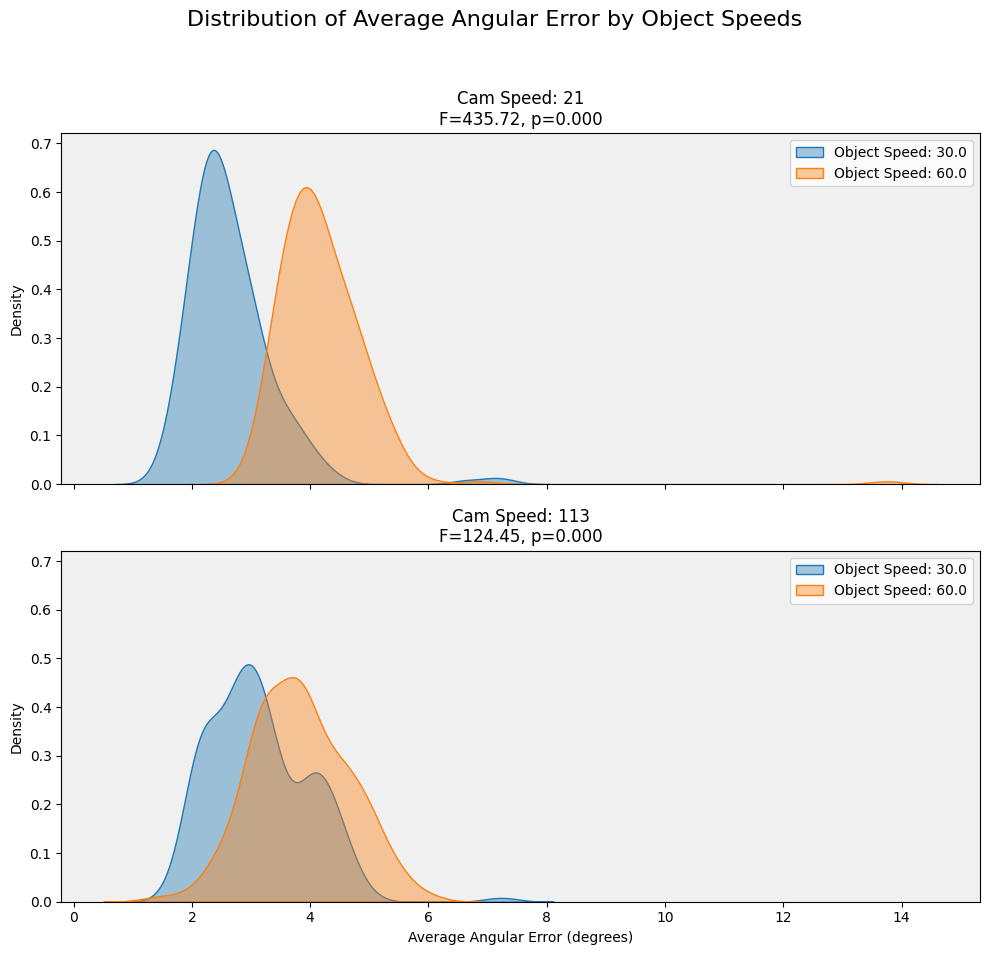

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns  # For smooth density plots

# Load the trial details CSV to map TrialID to camera motion type, object speed, and camera speed
trial_details_df = pd.read_csv("generated_trial_ids/generated_trials_ids.csv")
data = pd.read_csv('GazeData/gaze_data_all_trials.csv', sep=',')

# Map TrialID to camera motion type and object speed based on an external mapping file
def map_camera_motion_type_and_object_speed(data_df, trial_details_df):
    data_df = data_df.merge(trial_details_df[['trial_id', 'camera_motion_type', 'object_speed', 'camera_speed']],
                            left_on='TrialID', right_on='trial_id', how='left')
    return data_df

# Compute position-dependent angular error
def compute_position_dependent_angular_error(df, screen_width, screen_height, screen_diagonal_size, distance_to_screen):
    # Convert screen diagonal size to pixels
    diagonal_resolution = np.sqrt(screen_width**2 + screen_height**2)
    pixel_size = screen_diagonal_size / diagonal_resolution  # Inches per pixel
    distance_to_screen_pixels = distance_to_screen * (1 / pixel_size) * 39.37  # Convert meters to inches

    # Compute screen center
    screen_center_x = screen_width / 2
    screen_center_y = screen_height / 2

    # Compute distances
    df['PixelDistance'] = np.sqrt((df['MappedPogX'] - df['BallX'])**2 + (df['MappedPogY'] - df['BallY'])**2)
    df['TargetToCenterDistance'] = np.sqrt((df['BallX'] - screen_center_x)**2 + (df['BallY'] - screen_center_y)**2)

    # Adjust distance to screen based on target's position on screen
    df['DistanceToScreenAdjusted'] = np.sqrt(distance_to_screen_pixels**2 + df['TargetToCenterDistance']**2)

    # Compute angular error
    df['AngularError'] = np.degrees(np.arctan(df['PixelDistance'] / df['DistanceToScreenAdjusted']))
    
    return df

# Calculate average angular error per individual trial run across a given time frame for each condition
def calculate_average_angular_error_per_individual_trial(df, time_start=0, time_end=None, object_speed=None, camera_speed=None):
    filtered_df = df[(df['RelativeTime'] >= time_start) & (df['RelativeTime'] <= (time_end if time_end is not None else df['RelativeTime'].max()))]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]

    if object_speed is not None:
        filtered_df = filtered_df[filtered_df['object_speed'] == object_speed]
    if camera_speed is not None:
        filtered_df = filtered_df[np.isclose(filtered_df['camera_speed'], camera_speed, rtol=1)]

    # Calculate the average angular error per individual trial run within each TrialID
    avg_error_per_individual_trial = filtered_df.groupby(['object_speed', 'TrialID', 'TrialNumber'])['AngularError'].mean().reset_index()
    return avg_error_per_individual_trial

# Perform ANOVA on the average angular error per individual trial run across specified object speeds
def perform_anova_on_object_speeds(avg_error_per_individual_trial, object_speeds=None):
    if object_speeds is not None:
        avg_error_per_individual_trial = avg_error_per_individual_trial[avg_error_per_individual_trial['object_speed'].isin(object_speeds)]
    
    # Organize the data by object speed for ANOVA
    error_data = [avg_error_per_individual_trial[avg_error_per_individual_trial['object_speed'] == speed]['AngularError'] 
                  for speed in avg_error_per_individual_trial['object_speed'].unique()]

    if len(error_data) > 1:
        f_stat, p_value = f_oneway(*error_data)
        return {'F-statistic': f_stat, 'p-value': p_value}
    else:
        return {'F-statistic': None, 'p-value': None}  # Skip ANOVA if only one group

# Analyze combinations for angular error and compare object speeds
def analyze_combinations_by_object_speeds(data, time_ranges, object_speeds_to_compare, camera_speeds):
    num_combinations = len(camera_speeds) * len(object_speeds_to_compare)
    fig, axes = plt.subplots(len(camera_speeds), 1, figsize=(10, len(camera_speeds) * 5), sharex=True, sharey=True)
    fig.suptitle("Distribution of Average Angular Error by Object Speeds", fontsize=16)

    for i, cam_speed in enumerate(camera_speeds):
        time_start, time_end = time_ranges.get(cam_speed, (0, 4))  # Default time range if not in map
        
        avg_error_per_individual_trial = calculate_average_angular_error_per_individual_trial(
            data, time_start, time_end, camera_speed=cam_speed
        )
        
        anova_results = perform_anova_on_object_speeds(avg_error_per_individual_trial, object_speeds=object_speeds_to_compare)
        print(anova_results)
        
        # Get the subplot axes
        ax = axes[i] if len(camera_speeds) > 1 else axes
        
        # Shade the plot background gray if p-value is significant (p < 0.05)
        p_value = anova_results['p-value']
        if p_value is not None and p_value < 0.05:
            ax.set_facecolor('#f0f0f0')  # Light gray background for significant p-values
        
        # Plot a density plot of average angular error per individual trial for each object speed
        for speed in object_speeds_to_compare:
            speed_data = avg_error_per_individual_trial[avg_error_per_individual_trial['object_speed'] == speed]
            sns.kdeplot(speed_data['AngularError'], ax=ax, label=f"Object Speed: {speed}", fill=True, alpha=0.4)
        
        # Display ANOVA results in the title of each subplot
        f_stat = anova_results['F-statistic']
        ax.set_title(f"Cam Speed: {cam_speed}\nF={f_stat:.2f}, p={p_value:.3f}")
        ax.set_xlabel("Average Angular Error (degrees)")
        ax.set_ylabel("Density")
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Load the data into a pandas DataFrame
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# Define screen and experiment parameters
screen_width = 3840  
screen_height = 2160
screen_diagonal_size = 27.5  # inches
distance_to_screen = 0.5842  # meters

data['MappedPogX'] = data['BestPogX'] * screen_width
data['MappedPogY'] = data['BestPogY'] * screen_height

data[['BallX', 'BallY']] = data['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
data = data[(data['BallX'] >= 0) & (data['BallY'] >= 0)]

# Compute angular error
data = compute_position_dependent_angular_error(data, screen_width, screen_height, screen_diagonal_size, distance_to_screen)

# Map trial details
data = map_camera_motion_type_and_object_speed(data, trial_details_df)

# Define parameters
time_ranges = {
    21: (0.2, 5.0),  
    113: (0.6, 1.0),  
}
object_speeds_to_compare = [30.0, 60.0]  # Compare these object speeds
camera_speeds = [21, 113]  # Fixed camera speeds for comparison

# Analyze each combination of camera speeds and object speeds
analyze_combinations_by_object_speeds(data, time_ranges, object_speeds_to_compare, camera_speeds)
